In [6]:
from pathlib import Path
import numpy as np
import re
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import matplotlib.pyplot as plt

In [7]:
plt.rcParams['font.family'] = 'Times New Roman'

# Pipeline for Calculating Neural Alignment Using NOD Images

## Process the NOD fMRI RDMs for each region of interest.

For the purposes of our project, we will select regionss V1 and V2 to examine network associations with lower order regions in the visual stream; and we will select regions FFC and VVC to examine network associations with higher order regions in the visual stream. The options are V1, V2, V3, V4, V8, ventromedial visual areas (VMV1, VMV2, VMV3), posterior inferotemporal complex (PIT), lateral occipital (LO1, LO2, LO3), fusiform face complex (FFC), and ventral visual complex (VVC). 

In [107]:
nod_rdms_path = Path('/home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/outputs')

# get a list of all the folders in the NOD RDMs path that start with 'sub-'
nod_rdms_subject_folders = list(nod_rdms_path.glob("sub-*"))

# get a list of the files in each of the subject folders that start with 'V1', 'V2', 'FFC', or 'VVC'
nod_rdms_file_paths = []
for folder in nod_rdms_subject_folders:
    nod_rdms_file_paths.extend(list(folder.glob("*roi*")))
    # nod_rdms_file_paths.extend(list(folder.glob("V1_*")))
    # nod_rdms_file_paths.extend(list(folder.glob("V2_*")))
    # nod_rdms_file_paths.extend(list(folder.glob("FFC_*")))
    # nod_rdms_file_paths.extend(list(folder.glob("VVC_*")))

print(nod_rdms_file_paths)

fmri_nod_rdms = {}

for file_path in nod_rdms_file_paths:
    # extract the subject number from the file name
    subject_number = file_path.parent.name.split('-')[1]
    print(subject_number)
    # extract the roi from the file name
    roi = file_path.stem.split('_')[0]
    print(roi)
    fmri_rdm = np.load(file_path)
    print(fmri_rdm.shape)
    # store the fMRI RDM in the dictionary
    fmri_nod_rdms[subject_number + '_' + roi] = fmri_rdm

[PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/outputs/sub-21/VVC_roi_rdm_vector.npy'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/outputs/sub-21/VMV3_roi_rdm_vector.npy'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/outputs/sub-21/V2_roi_rdm_vector.npy'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/outputs/sub-21/LO2_roi_rdm_vector.npy'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/outputs/sub-21/VMV1_roi_rdm_vector.npy'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/outputs/sub-21/V1_roi_rdm_vector.npy'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/outputs/sub-21/LO1_roi_rdm_vector.npy'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/outputs/sub-21/PIT_roi_rdm_vector.npy'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/outputs/sub-21

In [108]:
# put the fmri_nod_rdms dictionary into order by the subject number
fmri_nod_rdms = dict(sorted(fmri_nod_rdms.items(), key=lambda x: x[0]))

print(fmri_nod_rdms)

# identify the shape of the fMRI RDMs
for key in fmri_nod_rdms:
    print(key)
    print(fmri_nod_rdms[key].shape)

{'01_FFC': array([0.26236227, 0.42347058, 0.3487565 , ..., 0.61466191, 0.67695688,
       0.65068813]), '01_LO1': array([0.30434719, 0.47524421, 0.55334705, ..., 0.8102264 , 0.72683246,
       0.95961295]), '01_LO2': array([0.31935476, 0.4584968 , 0.43046715, ..., 0.66553892, 0.97985713,
       0.90055285]), '01_LO3': array([0.15552975, 0.74407255, 0.48530613, ..., 0.79435655, 0.59327304,
       0.36895331]), '01_PIT': array([0.96250489, 0.94168529, 0.22935318, ..., 0.75501149, 1.06997943,
       0.86151413]), '01_V1': array([1.12186634, 0.71595029, 1.08821329, ..., 0.85956842, 1.22370319,
       0.73410845]), '01_V2': array([1.01236024, 0.64241136, 0.77960746, ..., 0.60692806, 1.07548846,
       0.77824067]), '01_V3': array([0.98808189, 0.52908383, 1.01070265, ..., 0.59662371, 0.86684586,
       0.84335184]), '01_V4': array([0.77420426, 0.48731738, 0.63304926, ..., 0.56900703, 1.09236996,
       0.88264519]), '01_V8': array([0.45340961, 0.60963806, 0.35946124, ..., 0.60808986, 0.81221

In [109]:
# examine how fmri_nod_rdms is structured
print(fmri_nod_rdms.keys())

# examine the shape of the fMRI RDMs for the first key
print(fmri_nod_rdms[list(fmri_nod_rdms.keys())[0]].shape)

print(fmri_nod_rdms['01_V1'])

dict_keys(['01_FFC', '01_LO1', '01_LO2', '01_LO3', '01_PIT', '01_V1', '01_V2', '01_V3', '01_V4', '01_V8', '01_VMV1', '01_VMV2', '01_VMV3', '01_VVC', '02_FFC', '02_LO1', '02_LO2', '02_LO3', '02_PIT', '02_V1', '02_V2', '02_V3', '02_V4', '02_V8', '02_VMV1', '02_VMV2', '02_VMV3', '02_VVC', '03_FFC', '03_LO1', '03_LO2', '03_LO3', '03_PIT', '03_V1', '03_V2', '03_V3', '03_V4', '03_V8', '03_VMV1', '03_VMV2', '03_VMV3', '03_VVC', '04_FFC', '04_LO1', '04_LO2', '04_LO3', '04_PIT', '04_V1', '04_V2', '04_V3', '04_V4', '04_V8', '04_VMV1', '04_VMV2', '04_VMV3', '04_VVC', '05_FFC', '05_LO1', '05_LO2', '05_LO3', '05_PIT', '05_V1', '05_V2', '05_V3', '05_V4', '05_V8', '05_VMV1', '05_VMV2', '05_VMV3', '05_VVC', '06_FFC', '06_LO1', '06_LO2', '06_LO3', '06_PIT', '06_V1', '06_V2', '06_V3', '06_V4', '06_V8', '06_VMV1', '06_VMV2', '06_VMV3', '06_VVC', '07_FFC', '07_LO1', '07_LO2', '07_LO3', '07_PIT', '07_V1', '07_V2', '07_V3', '07_V4', '07_V8', '07_VMV1', '07_VMV2', '07_VMV3', '07_VVC', '08_FFC', '08_LO1', '08

In [111]:
nod_rois = set()
for key in fmri_nod_rdms.keys():
    roi = key.split('_')[1]  # Extract ROI from key like '01_V1' -> 'V1'
    nod_rois.add(roi)

print("Available ROIs:", (nod_rois))

# Create a dictionary to store averaged RDM vectors for each ROI
nod_roi_average_rdms = {}

for roi in (nod_rois):
    print(f"\nProcessing ROI: {roi}")

    # Filter RDMs for this specific ROI
    roi_rdms = {k: v for k, v in fmri_nod_rdms.items() if k.split('_')[1] == roi}
    print(f"Found {len(roi_rdms)} RDMs for {roi}")

    # Stack the vectors into a single array
    # Each RDM is already flattened, so we can stack them directly
    roi_rdms_array = np.stack(list(roi_rdms.values()))
    print(f"Stacked array shape: {roi_rdms_array.shape}")

    # Calculate the average across subjects
    # axis=0 means we take the mean across subjects for each pairwise dissimilarity
    roi_average_vector = np.mean(roi_rdms_array, axis=0)
    print(f"Average vector shape: {roi_average_vector.shape}")

    # Store in the dictionary
    nod_roi_average_rdms[roi] = roi_average_vector
    
    # Print first 5 values as a sanity check
    print(f"First 5 values for {roi}: {roi_average_vector[:5]}")



Available ROIs: {'V3', 'FFC', 'LO3', 'PIT', 'V2', 'VMV1', 'LO2', 'V4', 'V8', 'VVC', 'V1', 'LO1', 'VMV2', 'VMV3'}

Processing ROI: V3
Found 30 RDMs for V3
Stacked array shape: (30, 499500)
Average vector shape: (499500,)
First 5 values for V3: [0.87308947 0.96866074 0.93281047 0.86092729 0.79997551]

Processing ROI: FFC
Found 30 RDMs for FFC
Stacked array shape: (30, 499500)
Average vector shape: (499500,)
First 5 values for FFC: [0.76274848 0.93168927 0.79638425 0.75662221 0.75189617]

Processing ROI: LO3
Found 30 RDMs for LO3
Stacked array shape: (30, 499500)
Average vector shape: (499500,)
First 5 values for LO3: [0.78231199 0.91078569 0.89942046 0.62983419 0.8575392 ]

Processing ROI: PIT
Found 30 RDMs for PIT
Stacked array shape: (30, 499500)
Average vector shape: (499500,)
First 5 values for PIT: [0.78914639 1.10386244 0.82008219 0.85423421 0.82801092]

Processing ROI: V2
Found 30 RDMs for V2
Stacked array shape: (30, 499500)
Average vector shape: (499500,)
First 5 values for V2: 

## Check category order in the NOD fMRI RDMs.

✅ The flattened RDMs are of length 499,500. NOD is made up of 1k object categories, which would make for 499.5k pairwise dissimilarities. 

In [ ]:
# /home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/scripts/create_subject_roi_rdms.py

        for region in regions:
            print(f"Processing region: {region} for subject: {subject} . . .")
            roi_indices = region_roi_indices[region]

            roi_beta_data = all_beta_data[:, roi_indices[0]]
            
            unique_categories = sorted(set(all_categories))
            label_to_index = {label: i for i, label in enumerate(unique_categories)}
            sorted_indices = sorted(range(len(all_categories)), key=lambda i: label_to_index[all_categories[i]])
            sorted_categories = [all_categories[i] for i in sorted_indices]

            sorted_activations = roi_beta_data[sorted_indices, :]
            sorted_fnames = [all_fnames[i] for i in sorted_indices]
            full_fpaths = [os.path.join(category, fname) for category, fname in zip(sorted_categories, sorted_fnames)]

In [8]:
import os
from pathlib import Path

def extract_sorted_categories_from_filenames(filenames_path):
    """
    Extract sorted unique categories from the filenames.txt file.
    
    The filenames are already in sorted order, so we extract unique categories
    while preserving their appearance order.
    
    Args:
        filenames_path: Path to the filenames.txt file
        
    Returns:
        tuple: (sorted_categories, category_counts)
    """
    # Read all file paths
    with open(filenames_path, 'r') as f:
        full_paths = [line.strip() for line in f if line.strip()]
    
    # Extract categories from paths (format is: "category/filename")
    categories = []
    for path in full_paths:
        # Split by '/' to get category and filename
        parts = path.split('\\')
        category = parts[0]  # First part is the category
        categories.append(category)
    
    # Get unique categories in order of first appearance
    # This preserves the sorted order from the original script
    unique_categories = []
    seen = set()
    for cat in categories:
        if cat not in seen:
            unique_categories.append(cat)
            seen.add(cat)
    
    # Count occurrences of each category
    from collections import Counter
    category_counts = Counter(categories)
    
    return unique_categories, category_counts

# Example usage: extract categories from one subject's file
# Adjust the path to your actual data location
base_dir = Path('/home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/outputs')
subject = 'sub-01'
filenames_path = base_dir / subject / 'filenames.txt'

if filenames_path.exists():
    print(f"File exists: {filenames_path}")
    sorted_categories, category_counts = extract_sorted_categories_from_filenames(filenames_path)

    # Read and inspect the file
    with open(filenames_path, 'r') as f:
        lines = f.readlines()

    print(f"\nNumber of lines: {len(lines)}")
    print(f"\nFirst 5 lines:")
    for i, line in enumerate(lines[:5]):
        print(f"  {i+1}: {repr(line)}")

    # Show last 5 lines
    print(f"\nLast 5 lines:")
    for i, line in enumerate(lines[-5:], len(lines)-4):
        print(f"  {i}: {repr(line)}")
    
    print(f"Found {len(sorted_categories)} unique categories")
    print(f"\nFirst 10 categories:")
    for i, cat in enumerate(sorted_categories[:10], 1):
        print(f"{i:3d}. {cat}")

    print(f"\nLast 10 categories:")
    start_num = len(sorted_categories) - 9
    for cat in sorted_categories[-10:]:
        print(f"{start_num:3d}. {cat}")
        start_num += 1
    
    # # Save the sorted categories to a file
    # output_path = base_dir / subject / 'sorted_categories.txt'
    # with open(output_path, 'w') as f:
    #     for category in sorted_categories:
    #         f.write(f"{category}\n")
    # print(f"\n✅ Sorted categories saved to: {output_path}")
else:
    print(f"❌ File not found: {filenames_path}")
    

File exists: /home/wallacelab/teba/multimodal_brain_inspired/NOD/Nick_RDMs/outputs/sub-01/filenames.txt

Number of lines: 1000

First 5 lines:
  1: 'n01440764\\n01440764_26515.JPEG\n'
  2: 'n01443537\\n01443537_21338.JPEG\n'
  3: 'n01484850\\n01484850_14377.JPEG\n'
  4: 'n01491361\\n01491361_6582.JPEG\n'
  5: 'n01494475\\n01494475_13173.JPEG\n'

Last 5 lines:
  996: 'n13044778\\n13044778_150.JPEG\n'
  997: 'n13052670\\n13052670_9901.JPEG\n'
  998: 'n13054560\\n13054560_12466.JPEG\n'
  999: 'n13133613\\n13133613_91095.JPEG\n'
  1000: 'n15075141\\n15075141_11565.JPEG\n'
Found 1000 unique categories

First 10 categories:
  1. n01440764
  2. n01443537
  3. n01484850
  4. n01491361
  5. n01494475
  6. n01496331
  7. n01498041
  8. n01514668
  9. n01514859
 10. n01518878

Last 10 categories:
991. n12768682
992. n12985857
993. n12998815
994. n13037406
995. n13040303
996. n13044778
997. n13052670
998. n13054560
999. n13133613
1000. n15075141


In [22]:
# Read all of the files from the path 'home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet'
imagenet_path = Path('/home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet')
# list all the files in the imagenet path that start with 'n'
imagenet_files = list(imagenet_path.glob("n*"))

print(imagenet_files)

file_categories = []
for path in imagenet_files:
    # Split by '/' to get category and filename
    parts = str(path).split('/')
    category = parts[-1]  # Last part is the category
    file_categories.append(category)

print(file_categories)

sorted_file_categories = sorted(set(file_categories))

print(sorted_file_categories)


import pandas as pd

# save out the sorted_file_categories to a csv file
sorted_file_categories_df = pd.DataFrame(sorted_file_categories, columns=['category'])
sorted_file_categories_df.to_csv('sorted_file_categories.csv', index=False)




[PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet/n03584254'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet/n03895866'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet/n02690373'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet/n03623198'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet/n02138441'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet/n01498041'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet/n02454379'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet/n01631663'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet/n02488702'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet/n02860847'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/imagenet/n02099712'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/NOD/i

In [ ]:
# check to see if the sorted_file_categories are the same as the sorted_categories
print(sorted_file_categories == sorted_categories)

True


## Load last-layer NOD embeddings from the baseline training run, create model last-layer RDMs, and perform RSA with neural data.

In [23]:
nod_baseline_embeddings_path = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior/inference_results/nod_inference_results')

# get all the files in the nod_baseline_embeddings_path that start with 'nod_embeddings_epoch'
nod_baseline_embeddings_files = list(nod_baseline_embeddings_path.glob('nod_embeddings_epoch*.csv'))

print(nod_baseline_embeddings_files)

# load the last-layer embeddings from each epoch in the nod_baseline_embeddings_files
nod_baseline_embeddings = []


[PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior/inference_results/nod_inference_results/nod_embeddings_epoch28.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior/inference_results/nod_inference_results/nod_embeddings_epoch54.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior/inference_results/nod_inference_results/nod_embeddings_epoch85.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior/inference_results/nod_inference_results/nod_embeddings_epoch53.csv'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior/inference_results/nod_inference_results/nod_embeddings_epoch82.csv'), PosixPath('/home/wallacelab/teba/multimodal_

In [24]:
baseline_hba_last_layer_embeddings = {}

# sort the nod_baseline_embeddings_files by the epoch number
nod_baseline_embeddings_files = sorted(nod_baseline_embeddings_files, key=lambda x: int(re.search(r'epoch(\d+)', x.stem).group(1)))

for file in nod_baseline_embeddings_files:
    # extract the epoch number from the file name
    epoch_number = int(re.search(r'epoch(\d+)', file.stem).group(1))
    print(f"Processing epoch {epoch_number}")
    
    # load the embeddings from the file
    embeddings_df = pd.read_csv(file)
    
    # add the embeddings to the baseline_hba_last_layer_embeddings_original dictionary
    baseline_hba_last_layer_embeddings[epoch_number] = embeddings_df
    
    

Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing epoch 50
Processin

In [193]:
# Check to make sure that the last layer embeddings take the shape (2000, 68) for each epoch in the baseline_hba_last_layer_embeddings dictionary
for epoch_number in baseline_hba_last_layer_embeddings:
    if baseline_hba_last_layer_embeddings[epoch_number].shape != (2000, 68):
        print(f"Epoch {epoch_number} has the wrong shape")

print(baseline_hba_last_layer_embeddings[1].shape)

(2000, 68)


In [194]:
# for each last layer embedding, group by the 'category' column and take the mean of the embeddings for each category
for epoch_number in baseline_hba_last_layer_embeddings:
    # remove the 'image' column that contains the image names
    baseline_hba_last_layer_embeddings[epoch_number] = baseline_hba_last_layer_embeddings[epoch_number].drop(columns=['image'])
    # group by the 'category' column and take the mean of the embeddings for each category
    baseline_hba_last_layer_embeddings[epoch_number] = baseline_hba_last_layer_embeddings[epoch_number].groupby('category').mean()

print(baseline_hba_last_layer_embeddings[1].shape)





(1000, 66)


In [195]:
baseline_hba_nod_category_rdms_dict = {}
baseline_rdm_matrix = {}

for epoch_number in baseline_hba_last_layer_embeddings:

    # Initialize the dictionary for this perturbation run
    baseline_hba_nod_category_rdms_dict[epoch_number] = {}

    baseline_rdm_matrix[epoch_number] = {}

    # take only the numeric columns of the dataframe
    baseline_hba_nod_category_embeddings = baseline_hba_last_layer_embeddings[epoch_number].iloc[:, 1:].to_numpy()
    print(baseline_hba_nod_category_embeddings.shape)

    # create a concept RDM from the concept embeddings and add it to a dictionary
    category_rdm = 1 - cosine_similarity(baseline_hba_nod_category_embeddings)
    baseline_rdm_matrix[epoch_number] = category_rdm
    np.fill_diagonal(category_rdm, 0)
    print(category_rdm.shape)
    upper_tri_indices = np.triu_indices_from(category_rdm, k=1)
    baseline_hba_nod_category_rdms_dict[epoch_number] = category_rdm[upper_tri_indices]

(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000, 1000)
(1000, 65)
(1000

## For each ROI in the nod_roi_average_rdms dictionary, compare the ROI brain RDM to the baseline model's last-layer RDM at each epoch.

In [172]:
# Create a list to hold results
rho_results = []

for epoch_number in baseline_hba_nod_category_rdms_dict:
    print(f'Processing Epoch: {epoch_number}')
    model_rdm = baseline_hba_nod_category_rdms_dict[epoch_number]
    for roi in nod_roi_average_rdms:
        print(f'Processing ROI: {roi}')
        brain_rdm = nod_roi_average_rdms[roi]
        rho, p_value = stats.spearmanr(brain_rdm, model_rdm)
        print(f"ROI: {roi}, Epoch: {epoch_number}, Rho: {rho}, P-value: {p_value}")
        # Save the results to the list as a dictionary
        rho_results.append({
            "epoch": epoch_number,
            "roi": roi,
            "rho": rho,
            "p_value": p_value
        })

# Convert the list of results to a DataFrame
rho_results_df = pd.DataFrame(rho_results)


Processing Epoch: 1
Processing ROI: V3
ROI: V3, Epoch: 1, Rho: -0.008456739593257058, P-value: 2.27396962718322e-09
Processing ROI: FFC
ROI: FFC, Epoch: 1, Rho: 0.1345253909472502, P-value: 0.0
Processing ROI: LO3
ROI: LO3, Epoch: 1, Rho: 0.07834737175043686, P-value: 0.0
Processing ROI: PIT
ROI: PIT, Epoch: 1, Rho: 0.09646895356512465, P-value: 0.0
Processing ROI: V2
ROI: V2, Epoch: 1, Rho: 0.0064782459262095575, P-value: 4.681940803691917e-06
Processing ROI: VMV1
ROI: VMV1, Epoch: 1, Rho: 0.003007955284884293, P-value: 0.033513141875765894
Processing ROI: LO2
ROI: LO2, Epoch: 1, Rho: 0.1394968806812671, P-value: 0.0
Processing ROI: V4
ROI: V4, Epoch: 1, Rho: -0.007601993844202902, P-value: 7.752450640248137e-08
Processing ROI: V8
ROI: V8, Epoch: 1, Rho: -0.005815900806788862, P-value: 3.9492192113934984e-05
Processing ROI: VVC
ROI: VVC, Epoch: 1, Rho: -0.02768880725647167, P-value: 2.634996529530635e-85
Processing ROI: V1
ROI: V1, Epoch: 1, Rho: 0.0076497952074029655, P-value: 6.4238

In [173]:
print(rho_results_df)

      epoch   roi       rho       p_value
0         1    V3 -0.008457  2.273970e-09
1         1   FFC  0.134525  0.000000e+00
2         1   LO3  0.078347  0.000000e+00
3         1   PIT  0.096469  0.000000e+00
4         1    V2  0.006478  4.681941e-06
...     ...   ...       ...           ...
1367     98   VVC  0.011358  9.961243e-16
1368     98    V1  0.013390  2.976495e-21
1369     98   LO1  0.075666  0.000000e+00
1370     98  VMV2  0.015696  1.345096e-28
1371     98  VMV3 -0.011128  3.700983e-15

[1372 rows x 4 columns]


In [174]:
# save the rho_results_df to a csv file
rho_results_df.to_csv('rho_results_df.csv', index=False)


In [10]:
# load baseline_brain_rsa_results.csv
rho_results_df = pd.read_csv('baseline_brain_rsa_results.csv')

print(rho_results_df)

      epoch   roi       rho       p_value
0         1    V3 -0.008457  2.273970e-09
1         1   FFC  0.134525  0.000000e+00
2         1   LO3  0.078347  0.000000e+00
3         1   PIT  0.096469  0.000000e+00
4         1    V2  0.006478  4.681941e-06
...     ...   ...       ...           ...
1367     98   VVC  0.011358  9.961243e-16
1368     98    V1  0.013390  2.976495e-21
1369     98   LO1  0.075666  0.000000e+00
1370     98  VMV2  0.015696  1.345096e-28
1371     98  VMV3 -0.011128  3.700983e-15

[1372 rows x 4 columns]


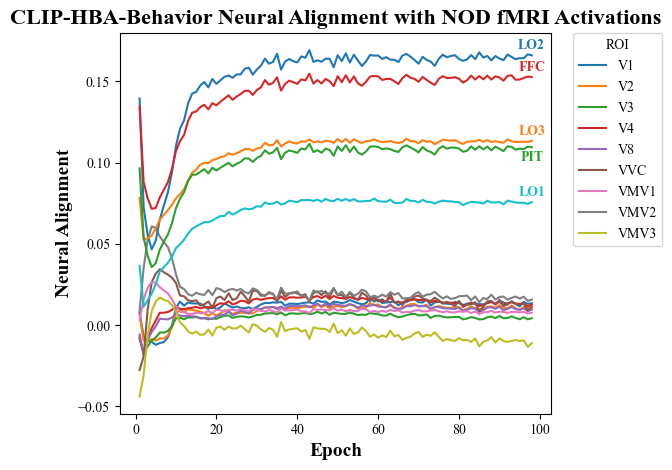

<Figure size 300x300 with 0 Axes>

In [22]:
# Plot rho vs epoch for each ROI on the same figure with different colors
import matplotlib.pyplot as plt

roi_order = ['V1', 'V2', 'V3', 'V4', 'V8', 'VVC', 'VMV1', 'VMV2', 'VMV3', 'LO1', 'LO2', 'LO3', 'PIT', 'FFC']
roi_text_labels = {'LO1', 'LO2', 'LO3', 'PIT', 'FFC'}

# For ROIs not to be shown in legend, we'll collect handles and labels separately
handles = []
labels = []

label_y_offset = 0.002  # Amount to nudge label above endpoint

for idx, roi in enumerate(roi_order):
    if roi in rho_results_df['roi'].unique():
        roi_df = rho_results_df[rho_results_df['roi'] == roi]
        # Plot the line for this ROI, but only include in legend if not in roi_text_labels
        if roi in roi_text_labels:
            handle, = plt.plot(roi_df['epoch'], roi_df['rho'], linestyle='-')
        else:
            handle, = plt.plot(roi_df['epoch'], roi_df['rho'], linestyle='-', label=roi)
            handles.append(handle)
            labels.append(roi)
        # Only add text labels for selected ROIs
        if roi in roi_text_labels and not roi_df.empty:
            x = roi_df['epoch'].iloc[-1]
            y = roi_df['rho'].iloc[-1]
            if roi == "PIT":
                # Put PIT 0.002 below the endpoint
                y_pos = y - 0.002
                va = "top"
            else:
                # Default: label above
                y_pos = y + label_y_offset
                va = "bottom"
            plt.text(
                x,                     # directly above the last point's epoch
                y_pos,                 # nudge upward or downward for clarity
                roi,
                color=handle.get_color(),
                va=va,                 # position label just above/below the marker
                ha='center',
                fontsize=10,
                fontweight='bold',
                bbox=dict(facecolor='white', edgecolor='none', pad=0.2, alpha=0.7)
            )

plt.xlabel('Epoch', fontweight='bold', fontsize=14)
plt.ylabel('Neural Alignment', fontweight='bold', fontsize=14)
plt.title('CLIP-HBA-Behavior Neural Alignment with NOD fMRI Activations', fontweight='bold', fontsize=16)
if handles and labels:
    plt.legend(handles, labels, title='ROI', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()
plt.gcf().set_size_inches(3, 3)



In [ ]:
# load the training results from the baseline training run
baseline_training_results_path = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior/training_results/training_res_.csv')
baseline_training_results = pd.read_csv(baseline_training_results_path)
print(baseline_training_results)


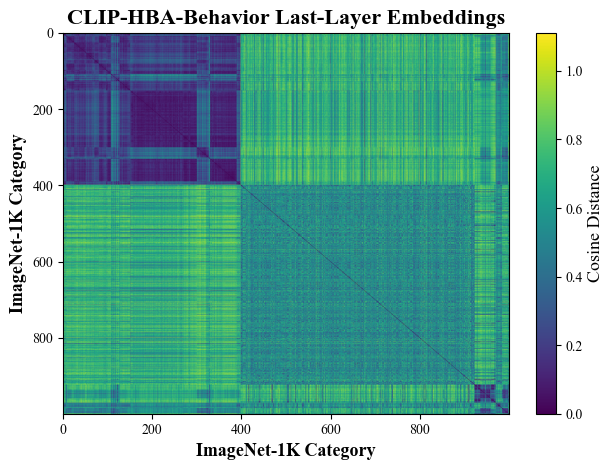

Minimum value: 0.0
Maximum value: 1.1112579999021013


<Figure size 300x300 with 0 Axes>

In [211]:
# Create a heatmap of the model last layer RDMs for each epoch
#plt.figure(figsize=(12, 7))

model_rdm = baseline_rdm_matrix[97]
plt.imshow(model_rdm, cmap='viridis', aspect='auto')
cbar = plt.colorbar()
cbar.set_label('Cosine Distance', fontsize=13)
plt.title('CLIP-HBA-Behavior Last-Layer Embeddings', fontweight='bold', fontsize=16)
plt.xlabel('ImageNet-1K Category', fontweight='bold', fontsize=13)
plt.ylabel('ImageNet-1K Category', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show()
plt.gcf().set_size_inches(3, 3)

# show the minimum and maximum values in the model_rdm
print(f"Minimum value: {np.min(model_rdm)}")
print(f"Maximum value: {np.max(model_rdm)}")


In [ ]:
# Create a heatmap of the RDMs for each ROI

# Reconstruct full RDM matrices from the upper triangular vectors
# Dictionary to store reconstructed RDMs
nod_fmri_reconstructed_rdms = {}

print("Reconstructing 1000x1000 RDMs from upper triangular vectors for NOD data...")
print("=" * 70)

plt.figure(figsize=(12, 7))

# Get the upper triangular indices for a 1000x1000 matrix, k=1 excludes diagonal
upper_tri_indices = np.triu_indices(1000, k=1)

print(f"Upper triangular indices shape: {upper_tri_indices[0].shape}")
print(f"Number of upper triangular elements: {len(upper_tri_indices[0])}")
print(f"Expected vector length: {len(upper_tri_indices[0])}")

# Loop through each ROI
for roi in sorted(nod_roi_average_rdms.keys()):
    print(f"\nProcessing ROI: {roi}")

    # Get the upper triangular vector
    upper_tri_vector = nod_roi_average_rdms[roi]
    print(f"  Upper triangular vector shape: {upper_tri_vector.shape}")
    print(f"  Vector length: {len(upper_tri_vector)}")

    # Verify the vector length matches expected
    expected_length = len(upper_tri_indices[0])
    if len(upper_tri_vector) != expected_length:
        print(f"  ⚠ Warning: Vector length {len(upper_tri_vector)} doesn't match expected {expected_length}")
    else:
        print(f"  ✓ Vector length matches expected")

    # Create empty RDM matrix
    rdm = np.zeros((1000, 1000))

    # Fill the upper triangular part
    rdm[upper_tri_indices] = upper_tri_vector

    # Fill the lower triangular part (RDM is symmetric) by taking the transpose
    rdm = rdm + rdm.T

    # Ensure diagonal is zero (it should already be since we're using triu with k=1)
    np.fill_diagonal(rdm, 0)

    # Store the reconstructed RDM
    nod_fmri_reconstructed_rdms[roi] = rdm


Reconstructing 1000x1000 RDMs from upper triangular vectors for NOD data...
Upper triangular indices shape: (499500,)
Number of upper triangular elements: 499500
Expected vector length: 499500

Processing ROI: FFC
  Upper triangular vector shape: (499500,)
  Vector length: 499500
  ✓ Vector length matches expected

Processing ROI: LO1
  Upper triangular vector shape: (499500,)
  Vector length: 499500
  ✓ Vector length matches expected

Processing ROI: LO2
  Upper triangular vector shape: (499500,)
  Vector length: 499500
  ✓ Vector length matches expected

Processing ROI: LO3
  Upper triangular vector shape: (499500,)
  Vector length: 499500
  ✓ Vector length matches expected

Processing ROI: PIT
  Upper triangular vector shape: (499500,)
  Vector length: 499500
  ✓ Vector length matches expected

Processing ROI: V1
  Upper triangular vector shape: (499500,)
  Vector length: 499500
  ✓ Vector length matches expected

Processing ROI: V2
  Upper triangular vector shape: (499500,)
  Vecto

NameError: name 'nod_reconstructed_rdms' is not defined

<Figure size 1200x700 with 0 Axes>

In [142]:


# Verify reconstruction by comparing with original data
print(f"\nReconstruction verification:")
for roi in sorted(nod_fmri_reconstructed_rdms.keys()):
    reconstructed_rdm = nod_fmri_reconstructed_rdms[roi]
    original_vector = nod_roi_average_rdms[roi]
    
    # Extract upper triangular from reconstructed RDM
    reconstructed_vector = reconstructed_rdm[upper_tri_indices]
    
    # Check if they match
    vectors_match = np.allclose(original_vector, reconstructed_vector)
    print(f"  {roi}: Vectors match = {vectors_match}")
    
    if not vectors_match:
        diff = np.abs(original_vector - reconstructed_vector)
        print(f"    Max difference: {np.max(diff):.10f}")
        print(f"    Mean difference: {np.mean(diff):.10f}")

# for roi in nod_roi_average_rdms:
#     brain_rdm = nod_roi_average_rdms[roi]
#     plt.imshow(brain_rdm, cmap='viridis', aspect='auto')
#     plt.colorbar(label='Pearson Distance')
#     plt.title(f'{roi} RDM')


Reconstruction verification:
  FFC: Vectors match = True
  LO1: Vectors match = True
  LO2: Vectors match = True
  LO3: Vectors match = True
  PIT: Vectors match = True
  V1: Vectors match = True
  V2: Vectors match = True
  V3: Vectors match = True
  V4: Vectors match = True
  V8: Vectors match = True
  VMV1: Vectors match = True
  VMV2: Vectors match = True
  VMV3: Vectors match = True
  VVC: Vectors match = True


In [25]:
# Create a heatmap of the model last layer RDMs for each epoch
#plt.figure(figsize=(6, 5))

model_rdm = nod_fmri_reconstructed_rdms['FFC']
plt.imshow(model_rdm, cmap='viridis', aspect='auto')
cbar = plt.colorbar()
cbar.set_label('Cosine Distance', fontsize=13)
clim=(min(0.0, np.min(rdm)), max(2.0, np.max(rdm)))
plt.title('NOD fMRI Activations - FFC', fontweight='bold', fontsize=16)
plt.xlabel('Category', fontweight='bold', fontsize=14)
plt.ylabel('Category', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()
plt.gcf().set_size_inches(3, 3)

NameError: name 'nod_fmri_reconstructed_rdms' is not defined

## Read in the NOD Model Embeddings from the single epoch perturbation sweep and create RDMs for the model.

In [3]:
# Directory containing the perturbation sweep results
perturbation_dir = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025')

# List all directories in the perturbation directory
perturbation_runs = list(perturbation_dir.glob('training_run*'))

# sort the perturbation runs by the number in the folder name
perturbation_runs = sorted(
    [p for p in perturbation_runs if re.search(r'\d+$', p.stem)],
    key=lambda p: int(re.search(r'\d+$', p.stem).group())
)

print(perturbation_runs)



[PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run1'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run2'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run3'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run4'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run5'), PosixPath('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run6'), PosixPath('/home/wallacelab/teba/multim

In [4]:
for run in perturbation_runs:
    # check for a folder called nod_inference_results
    if run.glob('nod_inference_results'):
        print(run)
        # print the number of files in the nod_inference_results folder
        print(len(list(run.glob('nod_inference_results/*')))) 
    else:
        print(f"No nod_inference_results found in {run}")


/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run1
98
/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run2
97
/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run3
84
/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run4
83
/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run5
82
/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run6
81
/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behav

In [5]:
# nod_embeddings_epochXX.csv

hba_last_layer_embeddings_original = {}

for run_path in perturbation_runs:
    # Extract training run number
    run_match = re.search(r'\d+$', run_path.stem)
    perturbation_run_number = int(run_match.group())
    print(f"Perturbation run number: {perturbation_run_number}")

    # Check for nod_inference_results folder
    nod_folder = run_path / 'nod_inference_results'
    print(f"Found NOD results folder in perturbation run {perturbation_run_number}")
    if not nod_folder.exists():
        print(f"No nod_inference_results found in {run_path}")
        continue

    # Get all CSV files in the nod_inference_results folder
    csv_files = list(nod_folder.glob('nod_embeddings_epoch*.csv'))
    print(f"Found CSV files for {len(csv_files)} epochs in {nod_folder}")

    # Initialize dictionary for this training run
    hba_last_layer_embeddings_original[perturbation_run_number] = {}

    # Extract epoch number from each file and load the embeddings
    csv_files = sorted(csv_files, key=lambda x: int(re.search(r'epoch(\d+)', x.stem).group(1)))

    for csv_file in csv_files:
        epoch_match = re.search(r'epoch(\d+)', csv_file.stem)
        if epoch_match:
            epoch_number = int(epoch_match.group(1))
            print(f"Processing epoch {epoch_number}")
            
            # Load the CSV file (contains image embeddings)
            embeddings_df = pd.read_csv(csv_file)
            hba_last_layer_embeddings_original[perturbation_run_number][epoch_number] = embeddings_df






# if len(list(run.glob('nod_inference_results/*'))) > 0:
#     # load the last-layer embeddings from each epoch in the nod_inference_results folder
#     nod_embeddings = []
#     for file in list(run.glob('nod_inference_results/*')):
#         nod_embeddings.append(np.load(file))
#     print(len(nod_embeddings))
#     print(nod_embeddings[0].shape)

Perturbation run number: 1
Found NOD results folder in perturbation run 1
Found CSV files for 98 epochs in /home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025/training_run1/nod_inference_results
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epo

In [42]:
hba_last_layer_embeddings = hba_last_layer_embeddings_original.copy()

In [43]:
# Check to make sure that the last layer embeddings take the shape (2000, 68) for each epoch in every perturbation run
for perturbation_run_number in hba_last_layer_embeddings:
    for epoch_number in hba_last_layer_embeddings[perturbation_run_number]:
        if hba_last_layer_embeddings[perturbation_run_number][epoch_number].shape != (2000, 68):
            print(f"Epoch {epoch_number} in perturbation run {perturbation_run_number} has the wrong shape")


In [44]:
# Check the columns of the first dataframe
first_run = list(hba_last_layer_embeddings.keys())[0]
first_epoch = list(hba_last_layer_embeddings[first_run].keys())[0]
df = hba_last_layer_embeddings[first_run][first_epoch]

print(f"Columns: {list(df.columns)}")
print(f"Shape: {df.shape}")
print(df.head())

Columns: ['image', 'category', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65']
Shape: (2000, 68)
                  image   category          0          1          2  \
0   n01440764_2271.JPEG  n01440764   9.846254  11.045237  12.740378   
1  n01440764_22706.JPEG  n01440764  10.155672  17.109623  14.940943   
2  n01443537_11665.JPEG  n01443537  13.146671  12.198559  14.333879   
3  n01443537_15966.JPEG  n01443537  12.940414  13.949488  16.276707   
4  n01484850_21794.JPEG  n01484850  12.635501  14.094557  15.532787   

           3          4          5          6          7  ...         56  \
0   9.802534   9.659874  11.428478  11.502826  10.712821  ... 

In [ ]:
# for each last layer embedding, group by the 'category' column and take the mean of the embeddings for each category
for perturbation_run_number in hba_last_layer_embeddings:
    for epoch_number in hba_last_layer_embeddings[perturbation_run_number]:
        # remove the 'image_name' column
        hba_last_layer_embeddings[perturbation_run_number][epoch_number] = hba_last_layer_embeddings[perturbation_run_number][epoch_number].drop(columns=['image'])
        # group by the 'category' column and take the mean of the embeddings for each category
        hba_last_layer_embeddings[perturbation_run_number][epoch_number] = hba_last_layer_embeddings[perturbation_run_number][epoch_number].groupby('category').mean()

In [46]:
# check the shape of the last layer embeddings
for perturbation_run_number in hba_last_layer_embeddings:
    for epoch_number in hba_last_layer_embeddings[perturbation_run_number]:
        print(f"Perturbation run number: {perturbation_run_number}, Epoch number: {epoch_number}")
        print(hba_last_layer_embeddings[perturbation_run_number][epoch_number].shape)



Perturbation run number: 1, Epoch number: 1
(1000, 66)
Perturbation run number: 1, Epoch number: 2
(1000, 66)
Perturbation run number: 1, Epoch number: 3
(1000, 66)
Perturbation run number: 1, Epoch number: 4
(1000, 66)
Perturbation run number: 1, Epoch number: 5
(1000, 66)
Perturbation run number: 1, Epoch number: 6
(1000, 66)
Perturbation run number: 1, Epoch number: 7
(1000, 66)
Perturbation run number: 1, Epoch number: 8
(1000, 66)
Perturbation run number: 1, Epoch number: 9
(1000, 66)
Perturbation run number: 1, Epoch number: 10
(1000, 66)
Perturbation run number: 1, Epoch number: 11
(1000, 66)
Perturbation run number: 1, Epoch number: 12
(1000, 66)
Perturbation run number: 1, Epoch number: 13
(1000, 66)
Perturbation run number: 1, Epoch number: 14
(1000, 66)
Perturbation run number: 1, Epoch number: 15
(1000, 66)
Perturbation run number: 1, Epoch number: 16
(1000, 66)
Perturbation run number: 1, Epoch number: 17
(1000, 66)
Perturbation run number: 1, Epoch number: 18
(1000, 66)
P

In [50]:
hba_nod_category_rdms_dict = {}

for perturbation_run_number in hba_last_layer_embeddings:

    # Initialize the dictionary for this perturbation run
    hba_nod_category_rdms_dict[perturbation_run_number] = {}

    for epoch_number in hba_last_layer_embeddings[perturbation_run_number]:
        print(f"Perturbation run number: {perturbation_run_number}, Epoch number: {epoch_number}")

        # take only the numeric columns of the dataframe
        hba_nod_category_embeddings = hba_last_layer_embeddings[perturbation_run_number][epoch_number].iloc[:, 1:].to_numpy()
        print(hba_nod_category_embeddings.shape)

        # create a concept RDM from the concept embeddings and add it to a dictionary
        category_rdm = 1 - cosine_similarity(hba_nod_category_embeddings)
        np.fill_diagonal(category_rdm, 0)
        print(category_rdm.shape)
        upper_tri_indices = np.triu_indices_from(category_rdm, k=1)
        hba_nod_category_rdms_dict[perturbation_run_number][epoch_number] = category_rdm[upper_tri_indices]

Perturbation run number: 1, Epoch number: 1
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 2
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 3
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 4
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 5
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 6
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 7
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 8
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 9
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 10
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 11
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 12
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 13
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 14
(1000, 65)
(1000, 1000)
Perturbation run number: 1, Epoch number: 1

In [51]:
output_folder = Path('/home/wallacelab/teba/multimodal_brain_inspired/marren/temporal_dynamics_of_human_alignment/clip_hba_behavior_loops/20251016_125025')

file_path = output_folder / 'hba_nod_category_rdms_dict.npz'


In [52]:

np.savez_compressed(str(file_path), **{f"run{r}_epoch{e}": data for r, epochs in hba_nod_category_rdms_dict.items() for e, data in epochs.items()})

# THINGS Pipeline for Reference

### Load fMRI RDMs for VA-1, VA-2, VA-3, left LOC, and right LOC.

In [ ]:
# Load all the files from the fmri_path directory that contain the word 'va-1', or 'va-2', or 'va-3'
fmri_path = Path('../../THINGS_fMRI/all_rdm')
fmri_files = list(fmri_path.glob("*va-1_*")) + list(fmri_path.glob("*va-2_*")) + list(fmri_path.glob("*va-3_*")) + list(fmri_path.glob("*lLOC*")) + list(fmri_path.glob("*rLOC*"))

# create a dictionary to store the fMRI RDMs
fmri_rdms = {}

for file in fmri_files:
    # extract the subject number from the file name
    subject_number = file.stem.split('_')[0].split('-')[1]
    print(subject_number)
    # extract the roi from the file name
    # This pattern is looking for the ROI name as the second element after splitting the filename (without extension) by underscores.
    if 'va' in file.stem:
        roi = file.stem.split('_')[2]
    else:
        roi = file.stem.split('_')[1]
    print(roi)
    fmri_rdm = np.load(file)
    print(fmri_rdm.shape)
    # store the fMRI RDM in the dictionary
    fmri_rdms[subject_number + '_' + roi] = fmri_rdm

# # print the first 5x5 of every fMRI RDM in the dictionary
for key in fmri_rdms:
    print(key)
    print(fmri_rdms[key][:5, :5])

### Get the variable names for our five ROIs.

In [ ]:
fmri_rdms_rois = list(set([key.split('_')[1] for key in fmri_rdms.keys()]))

print(fmri_rdms_rois)

for roi in fmri_rdms_rois:
    # Create a dictionary of RDMs for the current ROI, using the ROI name in the variable name
    roi_rdms_varname = f"{roi}_rdms"
    locals()[roi_rdms_varname] = {k: v for k, v in fmri_rdms.items() if roi in k}

    print(roi_rdms_varname)

### Load the concept index for the fMRI RDMs.

In [ ]:
# Loading the concept index for the fMRI RDM

concept_index = np.load('./concept_indices/sub-01_LOC_concept_index.npy')

print(concept_index)

### Read in the Stimulus Metadata file for each subject to ensure that all subjects were shown the same 8640 images making up the 720 concepts during fMRI trials.

In [ ]:
# Load the Stimulus Metadata file for each subject
sub_01_stimulus_metadata = pd.read_csv('sub-01_StimulusMetadata_train_only.csv').sort_values(by='concept').sort_values(by='stimulus')

# print the first 20 rows of the Stimulus Metadata file
#print(sub_01_stimulus_metadata.head(20))

sub_02_stimulus_metadata = pd.read_csv('sub-02_StimulusMetadata_train_only.csv').sort_values(by='concept').sort_values(by='stimulus')

#print(sub_02_stimulus_metadata.head(20))

sub_03_stimulus_metadata = pd.read_csv('sub-03_StimulusMetadata_train_only.csv').sort_values(by='concept').sort_values(by='stimulus')

#print(sub_03_stimulus_metadata.head(20))

# I want to test whether the stimulus column is exactly the same across all three subjects
# FIXED: Use reset_index(drop=True) to compare only values, not indices
print("Comparing stimulus columns (values only):")
print(sub_01_stimulus_metadata['stimulus'].reset_index(drop=True).equals(sub_02_stimulus_metadata['stimulus'].reset_index(drop=True)))
print(sub_01_stimulus_metadata['stimulus'].reset_index(drop=True).equals(sub_03_stimulus_metadata['stimulus'].reset_index(drop=True)))
print(sub_02_stimulus_metadata['stimulus'].reset_index(drop=True).equals(sub_03_stimulus_metadata['stimulus'].reset_index(drop=True)))

# Find and print rows where the 'stimulus' column differs across the three subjects

stim_01 = sub_01_stimulus_metadata['stimulus'].reset_index(drop=True)
stim_02 = sub_02_stimulus_metadata['stimulus'].reset_index(drop=True)
stim_03 = sub_03_stimulus_metadata['stimulus'].reset_index(drop=True)

# Find indices where any pair is not equal
diff_mask = ~((stim_01 == stim_02) & (stim_01 == stim_03) & (stim_02 == stim_03))

# Print the differing rows
if diff_mask.any():
    print("Rows where 'stimulus' column differs across subjects:")
    diff_df = pd.DataFrame({
        'row': stim_01.index[diff_mask],
        'sub_01_stimulus': stim_01[diff_mask].values,
        'sub_02_stimulus': stim_02[diff_mask].values,
        'sub_03_stimulus': stim_03[diff_mask].values
    })
    print(diff_df)
else:
    print("No differences found in the 'stimulus' column across the three subjects.")

### We can safely say that all three subjects were shown the same 12 images across all 720 object concepts. 

### Calculate the average concept RDM for each ROI across subjects.

In [ ]:
# Create averaged upper triangle vectors for all ROIs
# First, identify all unique ROIs from the fmri_rdms dictionary
rois = set()
for key in fmri_rdms.keys():
    roi = key.split('_')[1]  # Extract ROI from key like '01_lLOC' -> 'lLOC'
    rois.add(roi)

print("Available ROIs:", sorted(rois))

# Create a dictionary to store averaged upper triangle vectors for each ROI
roi_average_upper_triangles = {}

# Get upper triangular indices (same for all RDMs since they're all 720x720)
upper_tri_indices = np.triu_indices_from(fmri_rdms[list(fmri_rdms.keys())[0]], k=1)

for roi in sorted(rois):
    print(f"\nProcessing ROI: {roi}")
    
    # Filter RDMs for this specific ROI
    roi_rdms = {k: v for k, v in fmri_rdms.items() if roi in k}
    print(f"Found {len(roi_rdms)} RDMs for {roi}")
    
    # Extract upper triangular elements for each RDM
    roi_rdms_upper = {}
    for key in roi_rdms:
        roi_rdms_upper[key] = roi_rdms[key][upper_tri_indices]
    
    # Stack the vectors into a single array
    roi_rdms_upper_array = np.stack(list(roi_rdms_upper.values()))
    print(f"Stacked array shape: {roi_rdms_upper_array.shape}")
    
    # Calculate the average across subjects
    # axis=0 means we are taking the mean down the rows (i.e., column-wise), so for each position in the upper triangle vector, we average across all subjects' RDMs
    roi_average_upper_triangle = np.mean(roi_rdms_upper_array, axis=0)
    print(f"Average vector shape: {roi_average_upper_triangle.shape}")
    
    # Store in the dictionary
    roi_average_upper_triangles[roi] = roi_average_upper_triangle
    
    # Print first 5 values as a sanity check
    print(f"First 5 values for {roi}: {roi_average_upper_triangle[:5]}")

print(f"\nCreated averaged upper triangle vectors for {len(roi_average_upper_triangles)} ROIs:")
for roi in roi_average_upper_triangles:
    print(f"  {roi}: shape {roi_average_upper_triangles[roi].shape}")

### Average the fMRI activity between left and right LOC.

In [ ]:
roi_average_upper_triangles['LOC'] = np.mean(
    np.stack([roi_average_upper_triangles['lLOC'], roi_average_upper_triangles['rLOC']]), axis=0
)

print(roi_average_upper_triangles['LOC'].shape)

print(roi_average_upper_triangles['rLOC'].shape)

print(roi_average_upper_triangles.keys())

# remove the lLOC and rLOC keys
roi_average_upper_triangles.pop('lLOC')
roi_average_upper_triangles.pop('rLOC')

print(roi_average_upper_triangles.keys())

# Create feature-reweighting functions.

### Convert the vectors of fMRI RDMs averaged across subjects for each ROI back to 720x720 RDMs to ensure proper formatting for analysis.

In [ ]:
# Convert upper triangular vectors back to 720x720 RDMs (CORRECTED VERSION)
# This reconstructs the full RDM matrices from the upper triangular elements

# Dictionary to store reconstructed RDMs
roi_reconstructed_rdms = {}

print("Reconstructing 720x720 RDMs from upper triangular vectors (CORRECTED)...")
print("=" * 70)

# Get the upper triangular indices (same as used before)
upper_tri_indices = np.triu_indices(720, k=1)  # 720x720 matrix, k=1 excludes diagonal

print(f"Upper triangular indices shape: {upper_tri_indices[0].shape}")
print(f"Number of upper triangular elements: {len(upper_tri_indices[0])}")
print(f"Expected vector length: {len(upper_tri_indices[0])}")

# Loop through each ROI
for roi in sorted(roi_average_upper_triangles.keys()):
    print(f"\nProcessing ROI: {roi}")
    
    # Get the upper triangular vector
    upper_tri_vector = roi_average_upper_triangles[roi]
    print(f"  Upper triangular vector shape: {upper_tri_vector.shape}")
    print(f"  Vector length: {len(upper_tri_vector)}")
    
    # Verify the vector length matches expected
    expected_length = len(upper_tri_indices[0])
    if len(upper_tri_vector) != expected_length:
        print(f"  ⚠ Warning: Vector length {len(upper_tri_vector)} doesn't match expected {expected_length}")
    else:
        print(f"  ✓ Vector length matches expected")
    
    # Create empty RDM matrix
    rdm = np.zeros((720, 720))
    
    # Fill the upper triangular part
    rdm[upper_tri_indices] = upper_tri_vector
    
    # Fill the lower triangular part (RDM is symmetric) - CORRECTED METHOD
    # Use transpose to ensure perfect symmetry
    rdm = rdm + rdm.T
    
    # Ensure diagonal is zero
    np.fill_diagonal(rdm, 0)
    
    # Store the reconstructed RDM
    roi_reconstructed_rdms[roi] = rdm
    
    print(f"  Reconstructed RDM shape: {rdm.shape}")
    print(f"  RDM is symmetric: {np.allclose(rdm, rdm.T)}")
    print(f"  Diagonal is zero: {np.all(np.diag(rdm) == 0)}")
    print(f"  Min value: {np.min(rdm):.4f}")
    print(f"  Max value: {np.max(rdm):.4f}")
    print(f"  Mean value: {np.mean(rdm):.4f}")

print(f"\nSuccessfully reconstructed RDMs for {len(roi_reconstructed_rdms)} ROIs")
print(f"Available ROIs: {sorted(roi_reconstructed_rdms.keys())}")

# Verify reconstruction by comparing with original data
print(f"\nReconstruction verification:")
for roi in sorted(roi_reconstructed_rdms.keys()):
    reconstructed_rdm = roi_reconstructed_rdms[roi]
    original_vector = roi_average_upper_triangles[roi]
    
    # Extract upper triangular from reconstructed RDM
    reconstructed_vector = reconstructed_rdm[upper_tri_indices]
    
    # Check if they match
    vectors_match = np.allclose(original_vector, reconstructed_vector)
    print(f"  {roi}: Vectors match = {vectors_match}")
    
    if not vectors_match:
        diff = np.abs(original_vector - reconstructed_vector)
        print(f"    Max difference: {np.max(diff):.10f}")
        print(f"    Mean difference: {np.mean(diff):.10f}")

# Show how to access the reconstructed RDMs
print(f"\nExample usage:")
first_roi = sorted(roi_reconstructed_rdms.keys())[0]
print(f"  roi_reconstructed_rdms['{first_roi}']  # 720x720 RDM for {first_roi}")
print(f"  roi_reconstructed_rdms['{first_roi}'][:5, :5]  # First 5x5 of the RDM")

# Show a sample of the reconstructed RDM
sample_roi = sorted(roi_reconstructed_rdms.keys())[0]
sample_rdm = roi_reconstructed_rdms[sample_roi]
print(f"\nSample RDM ({sample_roi}) - first 5x5:")
print(sample_rdm[:5, :5])

### Define a function that uses ridge regression to generate weights for combining the 14 layer-level RDMs to predict a single neural RDM.

In [ ]:
def ridge_reweighting_single_rdm(
    model_rdms,  # Shape: [L, N, N]
    neural_rdm,   # Shape: [N, N] - single RDM
    alpha_candidates=None,
    cv_folds=5,
    objective='spearman'
):
    """
    Compute ridge weights combining layer model RDMs to predict a single neural RDM.
    
    Args:
        model_rdms: Model RDMs of shape [L, N, N]
        neural_rdm: Single neural RDM of shape [N, N]
        alpha_candidates: List of alpha values to test
        cv_folds: Number of cross-validation folds
        objective: 'spearman' or 'ridgecv'
        
    Returns:
        weights: Ridge weights of shape [L] - one weight per layer
        best_alpha: Best alpha value found
        cv_score: Cross-validation score
    """

    L, N, _ = model_rdms.shape
    
    # Build feature matrix X = upper-tri of each layer RDM -> [n_pairs, L]
    triu = torch.triu_indices(N, N, offset=1)
    n_pairs = triu.shape[1]
    X = np.zeros((n_pairs, L), dtype=np.float32)
    
    for l in range(L):
        rdm_l = model_rdms[l]
        X[:, l] = rdm_l[triu[0], triu[1]].astype(np.float32)
    
    # Extract target vector from neural RDM
    if isinstance(neural_rdm, torch.Tensor):
        y = neural_rdm[triu[0], triu[1]].cpu().numpy().astype(np.float32)
    else:
        y = neural_rdm[triu[0], triu[1]].astype(np.float32)
    
    alpha_candidates = alpha_candidates if alpha_candidates is not None else [1e-3, 1e-2, 1e-1, 1.0, 1e1, 1e2, 1e3]
    
    # Cross-validation to find best alpha
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=0)
    best_alpha = None
    best_score = -np.inf
    
    print(f"Cross-validating {len(alpha_candidates)} alpha values with {cv_folds} folds...")

    for alpha in tqdm(alpha_candidates, desc="Cross-validating alphas"):
        fold_scores = []
        
        for train_idx, val_idx in kf.split(X):
            X_tr, X_val = X[train_idx], X[val_idx]
            y_tr, y_val = y[train_idx], y[val_idx]
            
            if objective == 'spearman':
                # Rank-transform targets and center
                y_tr_rank = stats.rankdata(y_tr).astype(np.float32)
                y_tr_rank -= y_tr_rank.mean()
                
                model = Ridge(alpha=alpha, fit_intercept=False)
                model.fit(X_tr, y_tr_rank)
                y_val_pred = X_val @ model.coef_.astype(np.float32)
                
                rho, _ = stats.spearmanr(y_val_pred, y_val)
                if np.isnan(rho):
                    rho = 0.0
                fold_scores.append(float(rho))

            else:  # ridgecv objective
                # Center targets
                y_tr_centered = y_tr - y_tr.mean()
                y_val_centered = y_val - y_val.mean()
                
                model = Ridge(alpha=alpha, fit_intercept=False)
                model.fit(X_tr, y_tr_centered)
                y_val_pred = X_val @ model.coef_.astype(np.float32)
                
                # R² score
                ss_res = np.sum((y_val_centered - y_val_pred)**2)
                ss_tot = np.sum((y_val_centered - y_val_centered.mean())**2) + 1e-12
                r2 = 1.0 - ss_res/ss_tot
                fold_scores.append(float(r2))
        
        mean_score = float(np.mean(fold_scores))
        if mean_score > best_score:
            best_score = mean_score
            best_alpha = float(alpha)

    # Refit on full data with best alpha
    if objective == 'spearman':
        y_rank = stats.rankdata(y).astype(np.float32)
        y_rank -= y_rank.mean()
        final_model = Ridge(alpha=best_alpha, fit_intercept=False)
        final_model.fit(X, y_rank)
        weights = torch.from_numpy(final_model.coef_.astype(np.float32))
    else:
        y_centered = y - y.mean()
        final_model = Ridge(alpha=best_alpha, fit_intercept=False)
        final_model.fit(X, y_centered)
        weights = torch.from_numpy(final_model.coef_.astype(np.float32))
    
    print(f"Best alpha: {best_alpha}")
    print(f"CV score: {best_score:.4f}")
    
    return weights, best_alpha, best_score

### Define a function that computes a feature-reweighted model RDM from the ridge weights.

In [ ]:
def compute_reweighted_predictor(
    model_rdms,  # Shape: [L, N, N]
    weights     # Shape: [L] - ridge weights
):
    """
    Compute the reweighted predictor RDM by combining model RDMs with ridge weights.
    
    Args:
        model_rdms: Model RDMs of shape [L, N, N]
        weights: Ridge weights of shape [L]
        
    Returns:
        reweighted_rdm: Combined RDM of shape [N, N]
    """
    L, N, _ = model_rdms.shape
    
    # Convert weights to numpy if needed
    if isinstance(weights, torch.Tensor):
        weights = weights.cpu().numpy()
    
    # Initialize reweighted RDM
    reweighted_rdm = np.zeros((N, N), dtype=np.float32)
    
    # Weighted combination of model RDMs
    for l in range(L):
        reweighted_rdm += weights[l] * model_rdms[l]
    
    # Ensure symmetry (in case of numerical errors)
    reweighted_rdm = (reweighted_rdm + reweighted_rdm.T) / 2
    
    # Set diagonal to 0 (RDMs should have 0 on diagonal)
    np.fill_diagonal(reweighted_rdm, 0)

    return reweighted_rdm

### Define a function that will run the RDM feature-reweighting analysis.

In [ ]:
def run_single_rdm_analysis(
    model_rdms,      # Shape: [L, N, N]
    neural_rdm,      # Shape: [N, N]
    alpha_candidates=None,
    cv_folds=5,
    objective='spearman'
):
    """
    Complete pipeline for single RDM ridge regression analysis.
    
    Returns:
        weights: Ridge weights [L]
        best_alpha: Best alpha value
        cv_score: Cross-validation score
        reweighted_rdm: Predicted RDM [N, N]
        correlation: Correlation between predicted and actual RDM
    """
    print("Single RDM Ridge Regression Analysis")
    print("=" * 50)
    print(f"Model RDMs shape: {model_rdms.shape}")
    print(f"Neural RDM shape: {neural_rdm.shape}")
    print(f"Objective: {objective}")
    print(f"CV folds: {cv_folds}")
    
    # Compute ridge weights
    weights, best_alpha, cv_score = ridge_reweighting_single_rdm(
        model_rdms, neural_rdm, alpha_candidates, cv_folds, objective
    )
    
    # Compute reweighted predictor
    reweighted_rdm = compute_reweighted_predictor(model_rdms, weights)

    # Compute correlation between predicted and actual
    # Extract upper triangular parts for correlation
    triu = np.triu_indices(neural_rdm.shape[0], k=1)
    neural_flat = neural_rdm[triu]
    predicted_flat = reweighted_rdm[triu]
    
    if objective == 'spearman':
        correlation, _ = stats.spearmanr(neural_flat, predicted_flat)
    else:
        correlation, _ = stats.pearsonr(neural_flat, predicted_flat)
    
    print(f"\nResults:")
    print(f"Best alpha: {best_alpha}")
    print(f"CV score: {cv_score:.4f}")
    print(f"Final correlation: {correlation:.4f}")
    print(f"Weights: {weights.numpy()}")
    
    return {
        'weights': weights,
        'best_alpha': best_alpha,
        'cv_score': cv_score,
        'reweighted_rdm': reweighted_rdm,
        'correlation': correlation
    }